<a href="https://colab.research.google.com/github/Siwar-fatin/ESPITA-Formation-DeepLearning/blob/main/cancer_detection(cancer_des_poumons).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![espita77.jpeg](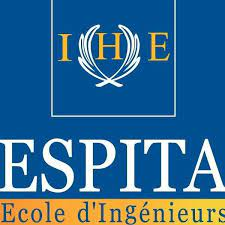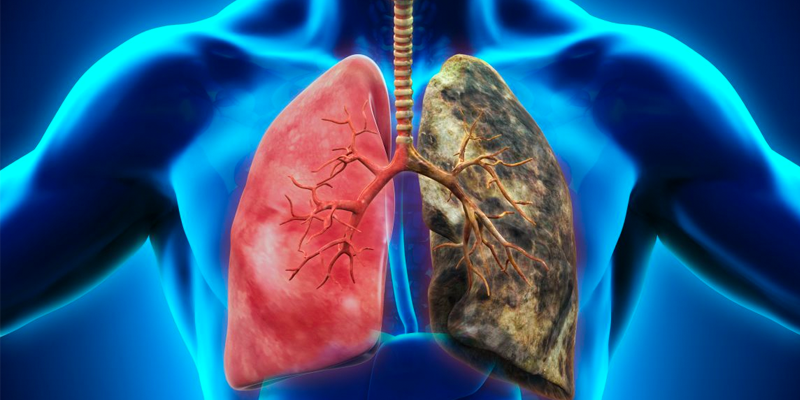)

**preparation de l'environemment**


In [1]:
pip install numpy

In [2]:
pip install pandas


In [ ]:
pip install tensorflow

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install opencv-python

# Detection de cancer des poumons

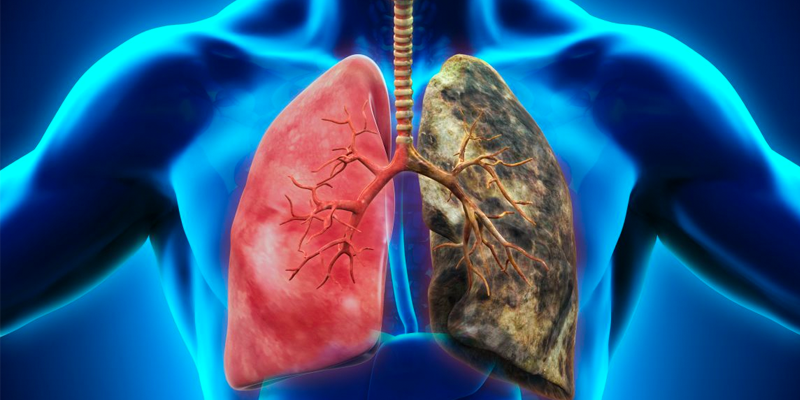

Dataset:https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images/data

# 1.Importation des bibliotheques

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

# 2.Importation de dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=('/content/drive/MyDrive/archive')

In [4]:
train_path_str='/content/drive/MyDrive/archive/Data/train'

In [5]:
val_path_str='/content/drive/MyDrive/archive/Data/valid'

In [6]:
test_path_str='/content/drive/MyDrive/archive/Data/test'

In [7]:
import os #lire eli f wost dossier exemple
test_classes=os.listdir(test_path_str)


# 3.pre-processing data

In [8]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout
#conv2d:couche de convolution 2d pour extraire des caracteristiques des images
#dense:couche de connx
#maxpo:couche de sous echantionnage qui reduit les dimns
#flatten:couchequi aplatit des donnes en entrees en un vecteur
#normalz: couche qui normalise les activites de la couche precedante
#droput: couche de regularisation pour prevenir le suraprentissage

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16 #extraction des carac
from tensorflow.keras.preprocessing.image import ImageDataGenerator #augmnt des donnees
from tensorflow.keras.applications.resnet import preprocess_input #pretraitement

import matplotlib.pyplot as plt #visualisation des courbes
import cv2 as cv

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle # Import shuffle from sklearn.utils

from keras.utils import to_categorical

In [10]:
# def de la forme des entrees de model
input_shape =(224,224,3)#les images sont 224*224 pixels avec 3 canaux de couleur RGB

In [11]:
#def du nombre  de classe de sortie
num_classes=4

In [12]:
#configuration du generateur d'image pour l'entrainement avec augm des donnes
trainGenerator= ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip= True,
    vertical_flip=True,
    dtype='float32'

)


In [13]:
valGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,

    dtype='float32'
)

In [14]:
testGenerator = ImageDataGenerator(
    preprocessing_function= preprocess_input,

    dtype = 'float32'
)

In [15]:
train_data= trainGenerator.flow_from_directory(
    train_path_str,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.


In [16]:
val_data= valGenerator.flow_from_directory(
    val_path_str,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 99 images belonging to 4 classes.


In [17]:
test_data= testGenerator.flow_from_directory(
    test_path_str,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 315 images belonging to 4 classes.


In [18]:
VGG16_model=VGG16(
    include_top=False, #ne pas inclure les couches de classification finale
    weights='imagenet',#utuliser les poids pre entainees sur le dataset
    input_shape = input_shape

)

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
for layer in VGG16_model.layers:
    layer.trainable =False



# 4.creation de modele

In [20]:
#creation d'un modele sequentiel
model=Sequential()
#ajout du modele VGG pre_entraine sans la chouche fully connected
model.add(VGG16_model)
#ajouter une couche de normalisation par lots pour ameliorer  la stabilite et la vitesse
model.add(BatchNormalization())
#ajoiter une couche de pooling max pour reduire la dimension des donnes
model.add(MaxPooling2D((2,2)))
#preparer les donnees a l'entree pour fully connected
model.add(Flatten())
#premier couche fully connected avec 1024 neurones actives par la fct relu
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.3)) #ajout d'une couche de regulation avec un taux 30%
#deuxieme couche fully connected avec 512 neurones actives par la fct relu
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3)) #ajout d'une couche de regulation avec un taux 30%
#troisieme couche fully connected avec 512 neurones actives par la fct relu
model.add(Dense(128,activation='relu'))
#couche de sortie avec un nombre de neurones egal au nombre de classes activees par la softmax
model.add(Dense(num_classes,activation='softmax'))
model.summary()#affichage de model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [21]:
callback= [
    tf.keras.callbacks.EarlyStopping(patience=5),  # Arrête l'entraînement si la métrique surveillée ne s'améliore plus après 5 epochs
    tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only = True), #sauvegarder le model dans un fichier h5
    tf.keras.callbacks.TensorBoard(log_dir='log') #Enregistre les logs pour visualiser les métriques d'entraînement dans TensorBoard
]

In [31]:
# Compile the model, including the 'accuracy' metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
resultat = model.fit(train_data, validation_data = val_data, epochs=150, verbose=1)

# Evaluate the model (this should now return both loss and accuracy)
loss, acc = model.evaluate(test_data, verbose= 1)

Epoch 1/150
39/39 [==============================] - 24s 543ms/step - loss: 0.1649 - accuracy: 0.9511 - val_loss: 1.3003 - val_accuracy: 0.8586
Epoch 2/150
39/39 [==============================] - 16s 415ms/step - loss: 0.1443 - accuracy: 0.9674 - val_loss: 1.5851 - val_accuracy: 0.8586
Epoch 3/150
39/39 [==============================] - 16s 422ms/step - loss: 0.1217 - accuracy: 0.9641 - val_loss: 1.4430 - val_accuracy: 0.8586
Epoch 4/150
39/39 [==============================] - 16s 417ms/step - loss: 0.1369 - accuracy: 0.9576 - val_loss: 1.5360 - val_accuracy: 0.8687
Epoch 5/150
39/39 [==============================] - 16s 411ms/step - loss: 0.1677 - accuracy: 0.9364 - val_loss: 1.3839 - val_accuracy: 0.8990
Epoch 6/150
39/39 [==============================] - 16s 419ms/step - loss: 0.1231 - accuracy: 0.9674 - val_loss: 1.2823 - val_accuracy: 0.8889
Epoch 7/150
39/39 [==============================] - 17s 428ms/step - loss: 0.2388 - accuracy: 0.9282 - val_loss: 1.5262 - val_accuracy:

In [32]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)

20/20 [==============================] - 4s 172ms/step
              precision    recall  f1-score   support

           0       0.40      0.44      0.42       120
           1       0.17      0.18      0.17        51
           2       0.20      0.19      0.19        54
           3       0.35      0.31      0.33        90

    accuracy                           0.32       315
   macro avg       0.28      0.28      0.28       315
weighted avg       0.31      0.32      0.32       315

